In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from simulation_functions import *
from tqdm import tqdm
from scipy.integrate import solve_ivp

In [8]:
ks = load_3d_matrix_from_csv("many_ks.csv")
Ks = load_3d_matrix_from_csv("many_KKs.csv")
g = Ks[0].shape[1]
lam = 5
lam = np.zeros(g)+lam
t_f = 200
m = 20
fitnesses = []
s_hats = []
lam_cs = []
dlambdas = []
for i in range(0,len(ks)):
    fitnesses.append(float(np.loadtxt("fitness" + str(i) + ".csv", delimiter=',')))
    s_hats.append((np.loadtxt("best_s_hat_" + str(i) + ".csv", delimiter=',')))
    lam_cs.append((np.loadtxt("best_lam_c" + str(i) + ".csv", delimiter=',')))
    n0 = np.zeros(g) + 0.5
    nt = simulate_dynamics(ks[i],Ks[i],lam,n0)
    n_f = nt[:,-1]
    J = calc_J(ks[i],Ks[i],n_f,lam)
    w, v = np.linalg.eig(J)
    w = np.real(w)
    dlambda_new = np.sort(w)[-2]/np.sort(w)[-1]
    dlambdas.append(dlambda_new)

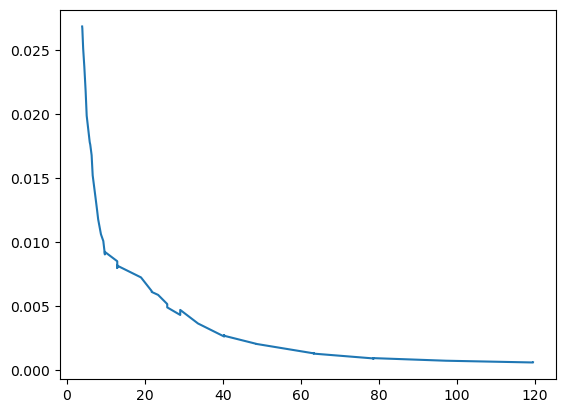

In [6]:
plt.plot(dlambdas,fitnesses)

In [11]:
i = 2
temperature = 1.0
cooling_rate = 0.96
num_iterations = 1000

lam_c, s_hat =  lam_cs[i],s_hats[i]
k = ks[i]
K = Ks[i]

n0 = np.zeros(g) + 0.5
nt = simulate_dynamics(k,K,lam,n0,thresh = 0.001, cutoff = 500000, dt = 0.01)
n_f = nt[:,-1]

J = calc_J(k,K,n_f,lam)
w, v = np.linalg.eig(J)
w = np.real(w)

current_dlambda = np.sort(w)[-2]/np.sort(w)[-1]

lambdas = []
is_connected = k != 0

best_k = k
best_K = K
best_cost = evaluate_fitness_controlled_norm(best_k,best_K,n_f,lam,lam_c,s_hat,m,t_f,g)

current_k = k
current_K = K
current_cost = evaluate_fitness_controlled_norm(current_k,current_K,n_f,lam,lam_c,s_hat,m,t_f,g)

costs = []

for kk in tqdm(range(2000)):
    
    lambdas.append(current_dlambda)
    costs.append(current_cost)
    l = np.random.randint(len(np.nonzero(is_connected)[0]))
    i, j = np.nonzero(is_connected)[0][l],np.nonzero(is_connected)[1][l]
    k_new = np.array(current_k)
    K_new = np.array(current_K)
    K_new[i,j] = K_new[i,j] + (np.random.rand() - 0.5)*2/5
    k_new[i,j] = k_new[i,j] + (np.random.rand() - 0.5)*2/5
    
    if k_new[i,j] < 1 and K_new[i,j] < 1 and K_new[i,j] > 0 and k_new[i,j]> 0:
        
        n0 = np.zeros(g) + 0.5
        nt = simulate_dynamics(k_new,K_new,lam,n0)
        n_f = nt[:,-1]
        
        J = calc_J(k_new,K_new,n_f,lam)
        w, v = np.linalg.eig(J)
        w = np.real(w)
        
        dlambda_new = np.sort(w)[-2]/np.sort(w)[-1]
        IPR_new = calc_IPR(w,v)
        new_cost = evaluate_fitness_controlled_norm(k_new,K_new,n_f,lam,lam_c,s_hat,m,t_f,g)
        
        if (IPR_new < 2/g) and (np.sort(w)[-1] < 0):
            if (new_cost < current_cost):
                current_k = k_new
                current_K = K_new
                current_dlambda = dlambda_new
                current_cost = new_cost
                if new_cost < best_cost:
                    best_k = k_new
                    best_K = K_new
                    best_cost = new_cost
            else:
                probability = np.exp((current_cost - new_cost) / temperature)
                if np.random.random() < probability:
                    current_k = k_new
                    current_K = K_new
                    current_dlambda = dlambda_new
                    current_cost = new_cost
        temperature *= cooling_rate

 29%|████████                    | 573/2000 [10:09<25:16,  1.06s/it]


KeyboardInterrupt: 

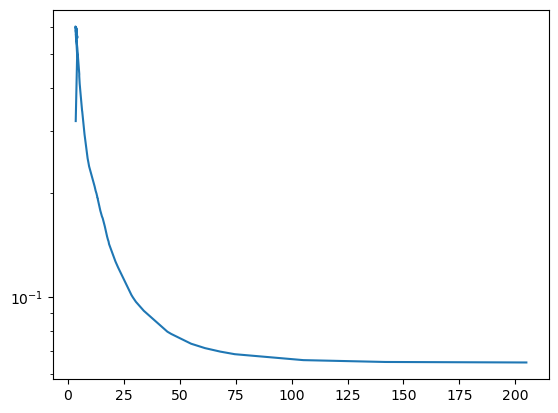

In [20]:
plt.plot(lambdas,costs)

plt.yscale('log')